In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import re
import string
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, backend as K, optimizers

from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords += [word.title() for word in eng_stopwords]
no_punct_table = str.maketrans(dict.fromkeys(string.punctuation)) # translation table to remove punctuation

%matplotlib inline

# Helper Functions

In [3]:
def preprocess(x):
    x = x.replace("<br />", '')
    x = x.translate(no_punct_table)
    x = ' '.join(list(filter(lambda y: y not in eng_stopwords, x.split(' '))))
    x = re.sub(r'[A-Z][a-z]+', "<name>", x)
    return x


def make_vocab(column):
    vocab_ = set()
    max_len_ = 0
    for sent in column:
        vocab_.update(sent.split(' '))
        max_len_ = max(max_len_, len(sent.split(' ')))
    
    vocab_.update(['<PAD>', '<UNK>']) # <PAD> and <UNK> tokens for padding and unknown words found in sentences
    
    return sorted(vocab_), max_len_


def pad_index_closure(mapping, ref_len):
    def inner(x):
        new_x = [mapping['<PAD>']] * (ref_len - len(x.split(' ')))
        
        for word in x.split(' '):
            try:
                new_word = mapping[word]
            except:
                new_word = mapping['<UNK>']
            
            new_x.append(new_word)
        
        return new_x
    
    return inner


def fix_array(arr):
    x_ = []
    for row in arr:
        x_.append(row)

    return np.array(x_)

# Reading the input dataset

In [4]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', header=0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Relabelling sentiment column
Replacing positive with 1 and negative with 0

In [5]:
df.sentiment = df.sentiment.apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Preprocessing

* Remove `<br />` tokens that are present in the text.
* Remove punctuation from the text.
* Remove stopwords.
* Substitute names of people with a special `<name>` token.

In [6]:
print("Before preprocessing:\n")
print(df.review[1])
print()
print("=" * 140)
df["review_preprocessed"] = df.review.apply(preprocess)

print("\nAfter preprocessing:\n")
print(df.review[1])

Before preprocessing:

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) ar

### Building the vocabulary of the dataset.
In the below cell, `vocab` is just a set.<br>

So, I will make a dictionary that will map each unique token in vocab to an integer.<br>
`vocab_itos` maps given integer to a word<br>
`vocab_stoi` maps given word to an integer

In [7]:
vocab, max_len = make_vocab(df.review_preprocessed)

vocab_itos = dict(enumerate(vocab))
vocab_stoi = {val: key for key, val in vocab_itos.items()}

### Converting the sequence of words to a sequence of integers
* Padding each sentence to make all the training examples of same length.
* Substituting each word for its corresponding integer

In [8]:
df["review_indexed"] = df.review_preprocessed.apply(pad_index_closure(vocab_stoi, max_len))
df.head()

,review,sentiment,review_preprocessed,review_indexed
0,One of the other reviewers has mentioned that ...,1,<name> reviewers mentioned watching 1 <name> e...,"[3840, 3840, 3840, 3840, 3840, 3840, 3840, 384..."
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[3840, 3840, 3840, 3840, 3840, 3840, 3840, 384..."
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[3840, 3840, 3840, 3840, 3840, 3840, 3840, 384..."
3,Basically there's a family where a little boy ...,0,<name> theres family little boy <name> thinks ...,"[3840, 3840, 3840, 3840, 3840, 3840, 3840, 384..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,<name> <name> <name> <name> <name> visually st...,"[3840, 3840, 3840, 3840, 3840, 3840, 3840, 384..."


## Get input and output arrays for the model

In [9]:
x = df.review_indexed.values
y = df.sentiment.values

# turn x into numpy array
x = fix_array(x)

# Build and train the model
* 1D Convolution
* LSTM layer
* Dense network
* Binary Cross Entropy loss with accuracy metric
* Adam optimizer

In [10]:
def get_model(input_length, embed_input_dim, embed_dim):
    K.clear_session()
    X_input =  layers.Input(shape=(input_length,))
    
    # An embedding layer that returns `embed_dim` sized vectors for each word
    X = layers.Embedding(input_dim=embed_input_dim, output_dim=embed_dim, input_length=input_length)(X_input)
    
    # 1D Conv layer to compute local features for each word
    X = layers.Conv1D(filters=10, kernel_size=3)(X)
    
    # LSTM layers to build a context vector of the input sentence
    X = layers.LSTM(X.shape[-1] // 2, return_sequences=True)(X)
    X = layers.LSTM(X.shape[-1] // 2)(X)
    
    # output Dense layer used for classification
    X = layers.Dense(1, activation='sigmoid')(X)
    
    # make the Model instance and return it
    return models.Model(inputs=X_input, outputs=X)

In [11]:
# make an instance of the model
model = get_model(x.shape[-1], len(vocab), 25)

# compile the model with Adam optimizer and Binary Cross Entropy loss with Accuracy metric
model.compile(optimizer=optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x, y, epochs=12, batch_size=8, validation_split=0.2).history

# Save the model in an h5 file
model.save("imdb_analyse_sentiment.h5")

Epoch 1/12
5000/5000 [==============================] - 497s 99ms/step - loss: 0.6922 - accuracy: 0.5814 - val_loss: 0.6909 - val_accuracy: 0.6440
Epoch 2/12
5000/5000 [==============================] - 494s 99ms/step - loss: 0.6839 - accuracy: 0.6649 - val_loss: 0.6717 - val_accuracy: 0.6749
Epoch 3/12
5000/5000 [==============================] - 495s 99ms/step - loss: 0.6275 - accuracy: 0.7217 - val_loss: 0.5781 - val_accuracy: 0.7697
Epoch 4/12
5000/5000 [==============================] - 501s 100ms/step - loss: 0.5389 - accuracy: 0.8199 - val_loss: 0.5232 - val_accuracy: 0.8263
Epoch 5/12
5000/5000 [==============================] - 502s 100ms/step - loss: 0.4967 - accuracy: 0.8417 - val_loss: 0.4953 - val_accuracy: 0.8263
Epoch 6/12
5000/5000 [==============================] - 503s 101ms/step - loss: 0.4618 - accuracy: 0.8596 - val_loss: 0.4694 - val_accuracy: 0.8383
Epoch 7/12
5000/5000 [==============================] - 508s 102ms/step - loss: 0.4308 - accuracy: 0.8720 - val_los

# Plotting the results

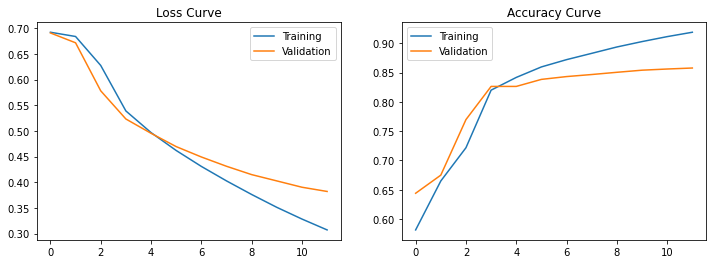

In [12]:
nrows = 1
ncols = 2
fig_size = plt.rcParams['figure.figsize']

fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))

_ = ax[0].plot(range(len(history['loss'])), history['loss'], label='Training')
if 'val_loss' in history.keys():
    _ = ax[0].plot(range(len(history['val_loss'])), history['val_loss'], label='Validation')
    _ = ax[0].legend()
_ = ax[0].set_title('Loss Curve')

_ = ax[1].plot(range(len(history['accuracy'])), history['accuracy'], label='Training')
if 'val_accuracy' in history.keys():
    _ = ax[1].plot(range(len(history['val_accuracy'])), history['val_accuracy'], label='Validation')
    _ = ax[1].legend()
_ = ax[1].set_title('Accuracy Curve')

### Testing the model with randomly sampled examples from the dataset

In [13]:
import random

NUM_EXAMPLES = int(0.1 * df.shape[0])
sampled_indices = random.sample(range(df.shape[0]), NUM_EXAMPLES)

# I have already preprocessed the text and converted them into sequences of integers and put them in a column called `review_indexed`.
# So, I'll take the examples from there.

# sampling the test examples and the ground truths
sampled_examples = fix_array(df.loc[sampled_indices, "review_indexed"].values)
y_true = df.loc[sampled_indices, "sentiment"].values

# Feeding the test examples to the models
y_pred = np.squeeze(model.predict(sampled_examples))


showing_indices = random.sample(range(NUM_EXAMPLES), 3)
for index in showing_indices:
    print(f"Review:\n{df.loc[index, 'review']}\n")
    print(f"Ground Truth: {'positive' if y_true[index] else 'negative'}")
    print(f"Predicted {'positive' if y_pred[index] >= 0.5 else 'negative'} with {(y_pred[index] if y_pred[index] >= 0.5 else 1 - y_pred[index]) * 100:.2f}% confidence\n")
    print("=" * 140)
    print()

y_pred = (y_pred >= 0.5).astype(int)

Review:
When Carol (Vanessa Hidalgo) starts looking into her brother's death, she begins to suspect something more sinister than "natural causes". The closer she gets to the truth, the more of a threat she becomes to her sister-in-law, Fiona (Helga Line), and the rest of the local Satanists. They'll do whatever is necessary to put a stop her nosy ways.<br /><br />If you're into sleazy, Satanic-themed movies, Black Candles has a lot to offer. The movie is filled with plenty of nudity and ritualistic soft-core sex. One scene in particular involving a young woman and a goat must be seen to be believed. Unfortunately, all the sleaze in the world can't save Black Candles. Most of the movie is a total bore. Other than the one scene I've already mentioned, the numerous sex scenes aren't shocking and certainly aren't sexy. The acting is spotty at best. Even genre favorite Helga Line gives a disappointing performance. The plot really doesn't matter. Its main function seems to be to hold the str

### Evaluating the performance of the model

Accuracy: 90.40%
Precision: 0.92
Recall: 0.89
F1 Score: 0.90


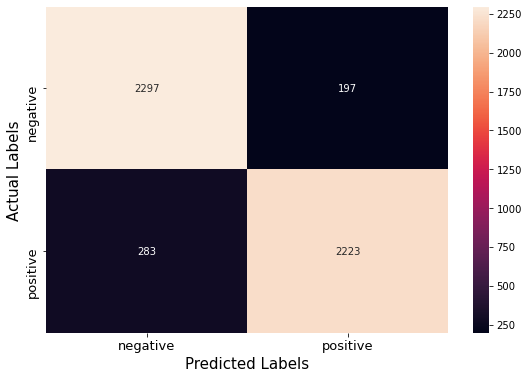

In [14]:
import seaborn as sns
from sklearn import metrics

accuracy = sum(y_true == y_pred) / NUM_EXAMPLES
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

_ = plt.figure(figsize=(fig_size[0] * 1.5, fig_size[1] * 1.5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
_ = ax.set_xticklabels(["negative", "positive"], fontsize=13)
_ = ax.set_yticklabels(["negative", "positive"], fontsize=13)
_ = ax.set_xlabel("Predicted Labels", fontsize=15)
_ = ax.set_ylabel("Actual Labels", fontsize=15)